In [23]:
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from livelossplot import PlotLosses
from transphone.data.utils import *
from transphone.data.loader import *
from transphone.data.dataset import *

In [8]:
dataset = read_dataset('eng')
training_cnt = int(len(dataset)*0.95)
test_cnt = len(dataset) - training_cnt

train_dataset, test_dataset = random_split(dataset, [training_cnt, test_cnt], generator=torch.Generator().manual_seed(42))
loader = read_loader(train_dataset, 64)
test_loader = read_loader(test_dataset, batch_size=1)

In [9]:
data = read_dataset()

In [11]:
data[0]

(tensor([66, 69, 60, 56, 65, 71]), tensor([28, 33, 32, 29, 14, 18]))

In [12]:
loader = DataLoader(data, shuffle=True, batch_size=8, collate_fn=collate)

In [13]:
it = iter(loader)

In [14]:
next(it)

(tensor([[45, 66, 69, 57, 52, 56, 65,  0,  0,  0],
         [70, 68, 72, 60, 70, 59,  0,  0,  0,  0],
         [47, 56, 65, 55, 52,  0,  0,  0,  0,  0],
         [73, 52, 69, 76,  0,  0,  0,  0,  0,  0],
         [33, 72, 63, 62,  0,  0,  0,  0,  0,  0],
         [71, 52, 65, 62, 56, 69,  0,  0,  0,  0],
         [67, 69, 60, 64, 56, 69,  0,  0,  0,  0],
         [71, 69, 60, 67, 52, 69, 71, 60, 71, 56]]),
 tensor([[18, 28, 33, 21,  2, 32, 14,  0,  0,  0],
         [17, 11, 22, 32, 35,  0,  0,  0,  0,  0],
         [21, 30, 14,  4, 29,  0,  0,  0,  0,  0],
         [21, 30, 29, 33,  9,  0,  0,  0,  0,  0],
         [ 8, 37, 12, 11,  0,  0,  0,  0,  0,  0],
         [18, 24, 26, 11, 29, 12,  0,  0,  0,  0],
         [16, 33,  2, 32, 13, 29, 33,  0,  0,  0],
         [18, 33,  2, 32, 16, 27, 18,  2, 32, 18]]))

In [26]:
class Encoder(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, layer_size):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, layer_size, batch_first=True)
        
    def forward(self, input_tensor):
        embed = self.embed(input_tensor)
        output, (hidden, _) = self.rnn(embed)
        
        return output, hidden
    
    
class Decoder(nn.Module):
    
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 1, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        
    def forward(self, input_tensor, prev_hidden, prev_cell):
        # input: [B]
        
        embed = self.embed(input_tensor)
        output, (hidden, cell) = self.rnn(embed, (prev_hidden, prev_cell))
        #print('after rnn', output)
        output = self.linear(output)
        #print('after linear:', output)
        output = self.logsoftmax(output)
        #print('after softmax', output)
        
        return output, hidden, cell

    
class AttentionDecoder(nn.Module):
    
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(2*hidden_size, hidden_size, 1, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.linearQ = nn.Linear(2*hidden_size, hidden_size)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        
    def forward(self, input_tensor, encoder_vector, prev_hidden, prev_cell):
        # input: [B, 1]
        # encoder: [B,T,H]
        # prev_hidden: (1,B,H)
        # prev_cell: (1,B,H)
        
        # [B,1,H]
        embed = self.embed(input_tensor).squeeze(1)
        
        # [B,2H] -> [B,H,1]
        Q = self.linearQ(torch.cat([embed, prev_hidden.squeeze(0)], dim=1)).unsqueeze(-1)
        K = encoder_vector
        
        # [B,T,H] [B,H,1] -> [B,T,1] -> [B,T] 
        attn_weights = F.softmax(torch.bmm(K, Q).squeeze(2), dim=1)
        
        # [B,H,T]x[B,T,1] -> [B,H,1] -> [B,H]
        attn_applied = torch.bmm(encoder_vector.transpose(1,2), attn_weights.unsqueeze(-1)).squeeze(2)
        
        # (B,2H) -> (B,1,2H)
        lstm_input = torch.cat([attn_applied, embed], dim=1).unsqueeze(1)
                       
        # [B,1,2H]
        output, (hidden, cell) = self.rnn(lstm_input, (prev_hidden, prev_cell))
                
        #print('after rnn', output)
        output = self.linear(output)
        #print('after linear:', output)
        output = self.logsoftmax(output)
        #print('after softmax', output)
        
        return output, hidden, cell
 
    
    
class AttnG2P(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = Encoder(200, 128, 1)
        self.decoder = AttentionDecoder(200, 128)     

In [15]:
def pad_sos_eos(ys, sos, eos):
    
    batch_size = len(ys)

    sos_tensor = ys.new_zeros((batch_size, 1)).fill_(sos)
    y_in = torch.cat([sos_tensor, ys], dim=1)
    
    y_out = []
    
    zero_tensor = ys.new_zeros((batch_size, 1))    
    extended_ys = torch.cat([ys, zero_tensor], dim=1)
    
    for y in extended_ys:
        eos_idx = (y==0).nonzero()[0].item()
        y[eos_idx] = eos        
        y_out.append(y)
        
    y_out = pad_list(y_out)
    return y_in, y_out

In [16]:
it = iter(loader)
batch = next(it)

In [17]:
batch

(tensor([[52, 74, 57, 72, 63,  0,  0,  0,  0,  0,  0,  0],
         [64, 66, 71, 59, 53, 52, 63, 63, 56, 55,  0,  0],
         [70, 67, 52, 71, 60, 52, 71, 56,  0,  0,  0,  0],
         [69, 56, 56, 55,  0,  0,  0,  0,  0,  0,  0,  0],
         [60, 65, 71, 56, 65, 71, 60, 73, 56,  0,  0,  0],
         [52, 55, 61, 66, 60, 65, 56, 55,  0,  0,  0,  0],
         [64, 56, 71, 52, 64, 66, 69, 67, 59, 60, 70, 64],
         [70, 59, 56, 56, 69,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([[28,  7, 36, 12,  0,  0,  0,  0,  0,  0,  0],
         [13, 15, 39,  3, 28, 12,  4,  0,  0,  0,  0],
         [17, 16,  6, 32, 35,  9,  6, 32, 18,  0,  0],
         [33,  9,  4,  0,  0,  0,  0,  0,  0,  0,  0],
         [32, 14, 18, 30, 14, 18, 32, 21,  0,  0,  0],
         [29,  5, 28, 32, 14,  4,  0,  0,  0,  0,  0],
         [13, 30, 18, 29, 13, 28,  7, 32, 23, 29, 13],
         [35, 32, 29,  0,  0,  0,  0,  0,  0,  0,  0]]))

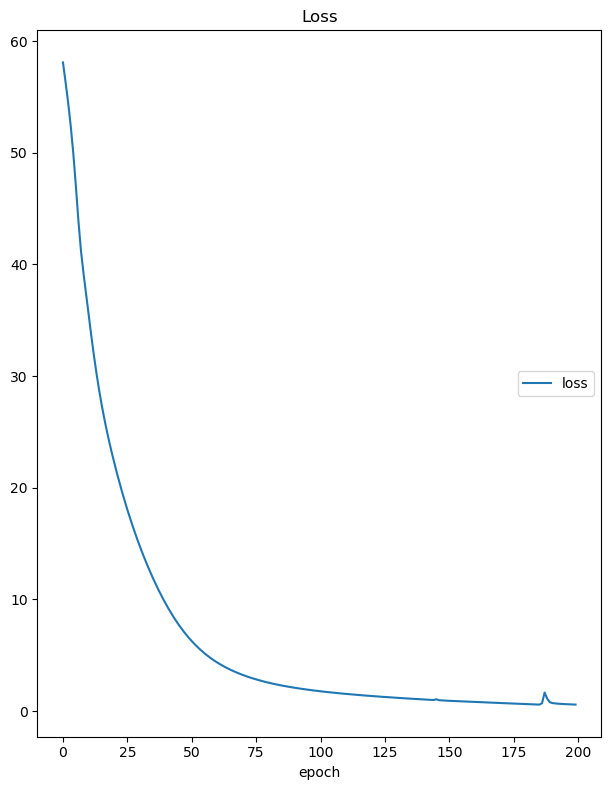

Loss
	loss             	 (min:    0.582, max:   58.091, cur:    0.583)


In [34]:
model = AttnG2P()
opt = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.NLLLoss(ignore_index=0)

it = iter(loader)

liveloss = PlotLosses()
batch = next(it)

for i in range(200):

    #batch = next(it)
    x, y = batch
    #print(x[0])
    #print(y[0])
    batch_size = x.shape[0]

    hidden_output, prev_hidden = model.encoder(x)
    prev_cell = x.new_zeros(1, batch_size, 128)

    ys_in, ys_out = pad_sos_eos(y, 1, 1)
    ys_in = ys_in.transpose(1,0)
    ys_out = ys_out.transpose(1,0)

    opt.zero_grad()
    
    loss = 0
    log = {}

    for i in range(len(ys_in)):
        y_in = ys_in[i].view(batch_size, 1)
        y_out = ys_out[i]
        output, prev_hidden, prev_cell = model.decoder(y_in, hidden_output, prev_hidden, prev_cell)

        output = output.squeeze()
        #print(y_out.shape)
        loss += criterion(output, y_out)

    loss.backward()
    opt.step()
    
    log['loss'] = loss.item()
    liveloss.update(log)
    liveloss.send()

In [20]:
a = torch.LongTensor([1,3,2])

In [23]:
a.topk(1)[1].item()

1

In [37]:
batch

(tensor([[70, 74, 66, 72, 58, 59,  0,  0,  0,  0],
         [37, 56, 73, 60, 71, 56,  0,  0,  0,  0],
         [54, 60, 69, 69, 59, 66, 70, 60, 70,  0],
         [57, 56, 70, 71, 60, 73, 56,  0,  0,  0],
         [70, 67, 69, 56, 52, 55, 52, 53, 63, 56],
         [70, 52, 64,  0,  0,  0,  0,  0,  0,  0],
         [27, 52, 71, 71, 56, 69, 70, 56, 52,  0],
         [71, 69, 52, 64, 66, 65, 71, 52, 65, 56]]),
 tensor([[17, 22,  2, 36,  0,  0,  0,  0,  0,  0],
         [12,  9, 21,  2, 32, 18,  0,  0,  0,  0],
         [17, 32, 33, 15, 36, 17, 32, 17,  0,  0],
         [ 7, 30, 17, 18, 32, 21,  0,  0,  0,  0],
         [17, 16, 33, 30,  4, 29,  3, 29, 12,  0],
         [17, 24, 13,  0,  0,  0,  0,  0,  0,  0],
         [ 3, 24, 18, 29, 17,  9,  0,  0,  0,  0],
         [18, 12, 29, 13, 15, 14, 18,  6, 32, 14]]))

In [38]:
model.eval()

    
x = torch.LongTensor([[70, 74, 66, 72, 58, 59,  0,  0,  0,  0]])

batch_size = 1

encoder_output, prev_hidden = model.encoder(x)
prev_cell = prev_hidden.new_zeros((1, batch_size, 128))

#print(prev_hidden)

#y_in = torch.LongTensor([[1]])
y_out = []

w = 1

while(True):
    y_in = torch.LongTensor([[w]])
    output, prev_hidden, prev_cell = model.decoder(y_in, encoder_output, prev_hidden, prev_cell)
    output = output.squeeze()
    #print(output)
    w = output.data.topk(1)[1].item()
    y_out.append(w)
    
    if w == 1 or len(y_out)>10:
        break

print(y_out)

[17, 22, 2, 36, 1]


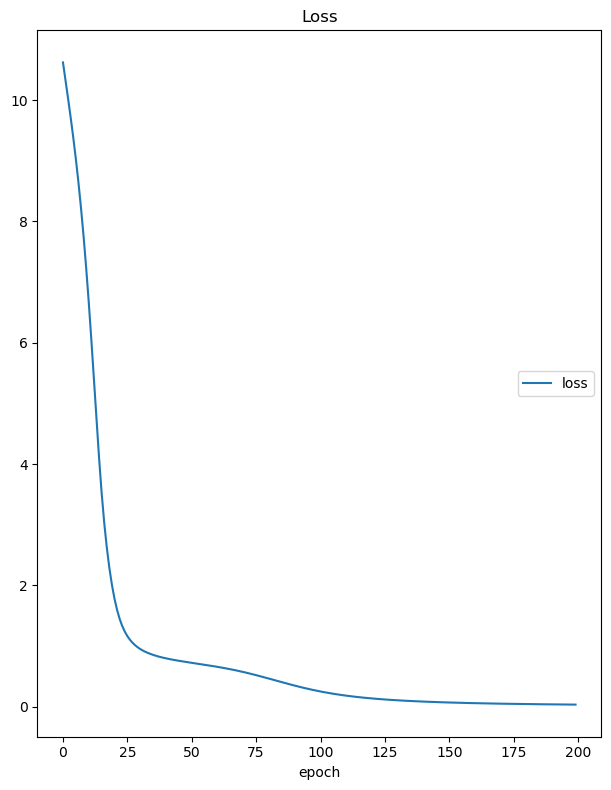

Loss
	loss             	 (min:    0.036, max:   10.621, cur:    0.036)


In [43]:
model = G2P()
opt = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.NLLLoss(ignore_index=0)

#it = iter(loader)

liveloss = PlotLosses()

batch = (torch.LongTensor([[2], [3]]), torch.LongTensor([[2], [3]]))

for i in range(200):

    #batch = next(it)
    x, y = batch
    #print(x[0])
    #print(y[0])
    batch_size = x.shape[0]

    output, prev_hidden = model.encoder(x)
    prev_cell = x.new_zeros(1, batch_size, 128)

    ys_in, ys_out = pad_sos_eos(y, 1, 1)
    ys_in = ys_in.transpose(1,0)
    ys_out = ys_out.transpose(1,0)

    opt.zero_grad()
    
    loss = 0
    log = {}

    for i in range(len(ys_in)):
        y_in = ys_in[i].view(batch_size, 1)
        y_out = ys_out[i]
        output, prev_hidden, prev_cell = model.decoder(y_in, prev_hidden, prev_cell)

        output = output.squeeze()
        #print(y_out.shape)
        loss += criterion(output, y_out)

    loss.backward()
    opt.step()
    
    log['loss'] = loss.item()
    liveloss.update(log)
    liveloss.send()